In [6]:
from __future__ import print_function 
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pickle
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.12.1+cu113
Torchvision Version:  0.13.1+cu113


In [15]:
# Top level data directory. Here we assume the format of the directory conforms
data_dir = "/content/drive/MyDrive/Alexnet"

# Models to choose from [resnet, alexnet, vgg, squeezenet, densenet, inception]
model_name = "alexnet"

# Number of classes in the dataset
num_classes = 8

# Batch size for training (change depending on how much memory you have)
batch_size = 512

# Number of epochs to train for 
num_epochs = 2

# Flag for feature extracting. When False, we finetune the whole model, 
#   when True we only update the reshaped layer params
feature_extract = True

In [16]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [17]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()
    
    return model_ft, input_size

# Initialize the model for this run
model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

# Print the model we just instantiated
print(model_ft)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [24]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'test']}

Initializing Datasets and Dataloaders...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [25]:
import json
id2lab= {i:class_name for i,class_name in enumerate(dataloaders_dict['train'].dataset.classes)}
lab2id = {class_name : i for i , class_name  in id2lab.items()}

In [26]:
id2lab

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___healthy'}

In [27]:
lab2id

{'Tomato___Bacterial_spot': 0,
 'Tomato___Early_blight': 1,
 'Tomato___Late_blight': 2,
 'Tomato___healthy': 3}

In [28]:
dataloaders_dict['train']

In [29]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [30]:
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 7419
     Root location: /content/drive/MyDrive/Alexnet/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ), 'test': Dataset ImageFolder
     Number of datapoints: 396
     Root location: /content/drive/MyDrive/Alexnet/test
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=bilinear, max_size=None, antialias=None)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [31]:
# Send the model to GPU
model_ft = model_ft.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are 
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.6.weight
	 classifier.6.bias


In [32]:
from sklearn.model_selection import KFold
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):

    since = time.time()

    val_acc_history = []
    val_loss_history = []
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_acc_history = [] 
    train_loss_history = [] 
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss

                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            # epoch_loss = epoch_loss.detach().cpu().numpy()
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            # epoch_acc = epoch_acc.detach().cpu().numpy()

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
              train_acc_history.append(epoch_acc)
              train_loss_history.append(epoch_loss)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history , val_loss_history, train_acc_history, train_loss_history


In [ ]:
# Setup the loss fxn
criterion = nn.CrossEntropyLoss()

# Train and evaluate
from sklearn.model_selection import KFold
n_fold = 5
kfold=KFold(n_splits=n_fold,shuffle=True)



initial_state = copy.deepcopy(model_ft.state_dict()) # Modelin ilk state


average_loss = 0 
best_loss = None
model_folder = '/content/drive/MyDrive/Alexnet/Model'
saved_model = None

for fold,(train_idx,val_idx) in enumerate(kfold.split(image_datasets['train'])):
  print()
  print('Fold {}/{}'.format(fold+1, n_fold))
  print('=' * 20)
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
  val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)

  trainloader = torch.utils.data.DataLoader(
                      image_datasets['train'], 
                      batch_size=batch_size, sampler=train_subsampler)
  valloader = torch.utils.data.DataLoader(
                      image_datasets['train'],
                      batch_size=batch_size, sampler=val_subsampler)
  model_ft.load_state_dict(initial_state)

  model_ft, val_acc_history , val_loss_history,train_acc_history,train_loss_history = train_model(model_ft,{'train' : trainloader , 'val' :valloader } , criterion, optimizer_ft, num_epochs=num_epochs)
  fold_loss = np.average(val_loss_history)
  average_loss += fold_loss
  if best_loss== None or fold_loss < best_loss:
    best_loss = fold_loss
    saved_model= copy.deepcopy(model_ft.state_dict())


print()
print('Average Loss = ', average_loss / n_fold )
print()


In [41]:
directory=model_name
path=os.path.join(model_folder, directory)
os.makedirs(path , exist_ok=True)
torch.save(saved_model, os.path.join(path , 'pytorch_model.bin'))
import pickle 
with open(os.path.join(path , 'labels.pkl') , 'wb') as fp :
  pickle.dump([id2lab,lab2id] , fp)

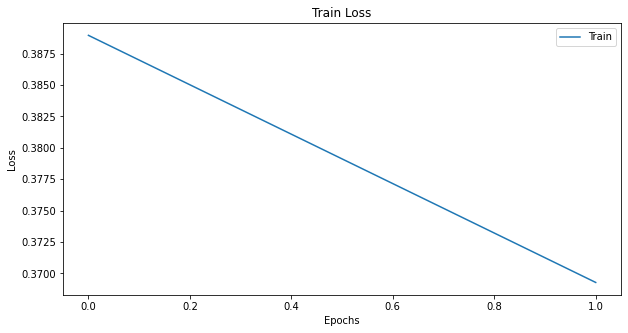

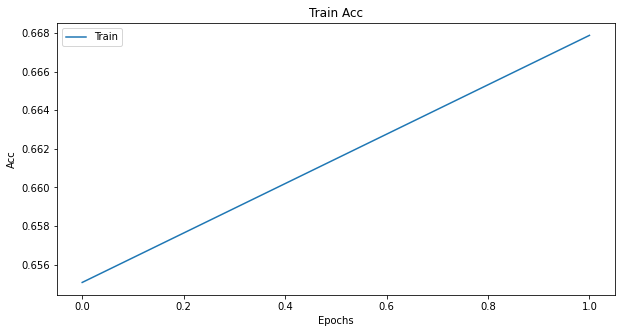

In [42]:
plt.figure(figsize=(10,5))
plt.title("Train Loss")
plt.plot(train_loss_history,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.title("Train Acc")
plt.plot(train_acc_history,label="Train")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()

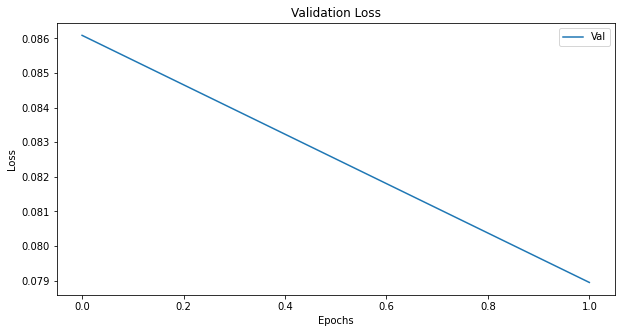

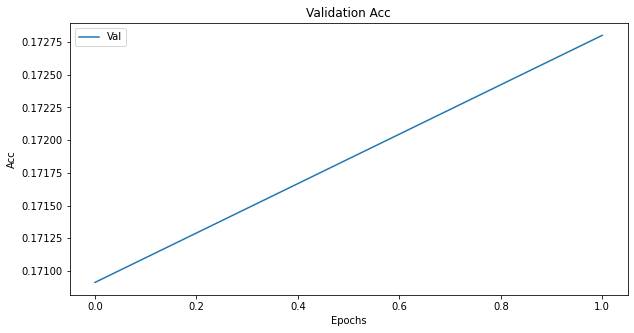

In [43]:
plt.figure(figsize=(10,5))
plt.title("Validation Loss")
plt.plot(val_loss_history,label="Val")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()


plt.figure(figsize=(10,5))
plt.title("Validation Acc")
plt.plot(val_acc_history,label="Val")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.legend()
plt.show()

In [47]:
model_folder = '/content/drive/MyDrive/Alexnet/Model/alexnet'

In [48]:
model_ft.load_state_dict(torch.load(os.path.join(model_folder , 'pytorch_model.bin')))

<All keys matched successfully>

In [51]:
with open(os.path.join(model_folder , 'labels.pkl') , 'rb') as fp :
  id2lab,lab2id = pickle.load(fp)

In [52]:
model_ft.eval()

since = time.time()
val_acc_history = []
val_loss_history = []
best_acc = 0.0


running_loss = 0.0
running_corrects = 0

# Iterate over data.
for inputs, labels in dataloaders_dict['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)
    # track history if only in train
    with torch.set_grad_enabled(False):
        outputs = model_ft(inputs)
        _, preds = torch.max(outputs, 1)
    running_corrects += torch.sum(preds == labels.data)

In [53]:
running_corrects / len( dataloaders_dict['test'])

tensor(331.)

In [54]:
running_corrects

tensor(331)

In [55]:
running_loss

0.0

In [57]:
len(os.listdir('/content/drive/MyDrive/Alexnet/test/Tomato___Bacterial_spot'))

99

In [58]:
#Test One Image
model_ft.eval()
from PIL import Image
def test_one_image(model_ft,data_transforms, image_path) :
  im = Image.open(image_path)
  im = data_transforms['test'](im)
  im = torch.unsqueeze(im, 0).to(device)
  with torch.set_grad_enabled(False):
      outputs = model_ft(im)
      _, preds = torch.max(outputs, 1)
      return preds.detach().cpu().numpy()

In [59]:
id2lab

{0: 'Tomato___Bacterial_spot',
 1: 'Tomato___Early_blight',
 2: 'Tomato___Late_blight',
 3: 'Tomato___healthy'}

In [63]:
preds = test_one_image(model_ft, data_transforms , '/content/drive/MyDrive/Alexnet/test/Tomato___Early_blight/1bb0101c-d0a4-41a5-85b9-6e8634d01a36___RS_Erly.B 9585.JPG')

In [64]:
print(preds)

[1]
